In [1]:
import pandas as pd
import numpy as np
import pyreadstat

In [2]:
# Variables:

# Consensus gradings file:
consensus = '../../data/nfbc/p0741_c6646c_dd_konsensus.csv'
gt_pf = pd.read_csv(consensus)

# Modic changes file:
mc = '../../data/nfbc/all_variables_consensus_subset.csv'
gt_mc = pd.read_csv(mc)

# SpineNet results:
sn = '../data/SpineNet_output.csv'
sn = pd.read_csv(sn)

# LBP data:
lbp, _ = pyreadstat.read_sas7bdat('../../data/nfbc/p0741_c6646_poiminta.sas7bdat')

# Levels of interest:
levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]

# MC columns:
mc_type_rostral = ['C6646C_lsMRI_mc1r', 'C6646C_lsMRI_mc2r','C6646C_lsMRI_mc3r','C6646C_lsMRI_mc4r','C6646C_lsMRI_mc5r']
mc_type_caudal = ['C6646C_lsMRI_mc1c', 'C6646C_lsMRI_mc2c', 'C6646C_lsMRI_mc3c', 'C6646C_lsMRI_mc4c', 'C6646C_lsMRI_mc5c']
mc_height_rostral = ['C6646C_lsMRI_mc1rh', 'C6646C_lsMRI_mc2rh','C6646C_lsMRI_mc3rh','C6646C_lsMRI_mc4rh','C6646C_lsMRI_mc5rh']
mc_height_caudal = ['C6646C_lsMRI_mc1ch', 'C6646C_lsMRI_mc2ch', 'C6646C_lsMRI_mc3ch', 'C6646C_lsMRI_mc4ch', 'C6646C_lsMRI_mc5ch']
mc_width_rostral = ['C6646C_lsMRI_mc1rw', 'C6646C_lsMRI_mc2rw','C6646C_lsMRI_mc3rw','C6646C_lsMRI_mc4rw','C6646C_lsMRI_mc5rw']
mc_width_caudal = ['C6646C_lsMRI_mc1cw', 'C6646C_lsMRI_mc2cw', 'C6646C_lsMRI_mc3cw', 'C6646C_lsMRI_mc4cw', 'C6646C_lsMRI_mc5cw']
mc_width = [mc_width_rostral, mc_width_caudal]
mc_type = [mc_type_rostral, mc_type_caudal]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/nfbc/p0741_c6646c_dd_konsensus.csv'

In [ ]:
# Upload consensus gradings and merge these into the SpineNet output:

# Convert from wide to long:
gt_pf = pd.melt(gt_pf, id_vars= ["project_ID"], value_vars=["L1L2","L2L3","L3L4","L4L5","L5S1"], var_name = "Level", value_name = "gt_pf")

# Match the format of the level labeling:
to_be_replaced = ["L1L2","L2L3","L3L4","L4L5","L5S1"]
for i in range(len(to_be_replaced)):
    gt_pf['Level'] = gt_pf['Level'].str.replace(to_be_replaced[i], levels[i])

In [ ]:
# Convert horizontal width zones to integers for Modic changes:
for j in mc_width:
    for i in j:
        gt_mc[i] = gt_mc[i].str.replace(',', '')
        gt_mc[i] = gt_mc[i].str.replace('0', '1111111111')
        gt_mc[i]=gt_mc[i].str.len()
        gt_mc[i]=gt_mc[i].replace(10, 0)
        gt_mc[i]=gt_mc[i].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [ ]:
# Convert Modic changes from wide to long:
gt_mc_r_t = pd.melt(gt_mc, id_vars= ["project_ID"], value_vars=mc_type_rostral, var_name = "Level", value_name = "gt_mc_r_t")
gt_mc_c_t = pd.melt(gt_mc, id_vars= ["project_ID"], value_vars=mc_type_caudal, var_name = "Level", value_name = "gt_mc_c_t")
gt_mc_r_w = pd.melt(gt_mc, id_vars= ["project_ID"], value_vars=mc_width_rostral, var_name = "Level", value_name = "gt_mc_r_w")
gt_mc_c_w = pd.melt(gt_mc, id_vars= ["project_ID"], value_vars=mc_width_caudal, var_name = "Level", value_name = "gt_mc_c_w")

In [ ]:
# convert the 5 possible Modic change entries into a binary present or absent and place in a new column:
gt_mc_r_t["gt_mc_r_t"] = gt_mc_r_t["gt_mc_r_t"].fillna(0)
gt_mc_r_t['gt_mc_r'] = np.where(gt_mc_r_t["gt_mc_r_t"] != 0, 1, gt_mc_r_t["gt_mc_r_t"])
gt_mc_c_t["gt_mc_c_t"] = gt_mc_c_t["gt_mc_c_t"].fillna(0)
gt_mc_c_t['gt_mc_c'] = np.where(gt_mc_c_t["gt_mc_c_t"] != 0, 1, gt_mc_c_t["gt_mc_c_t"])

In [ ]:
# Match the format of the level labeling:
for i in range(len(mc_type_rostral)):
    gt_mc_r_t['Level'] = gt_mc_r_t['Level'].str.replace(mc_type_rostral[i], levels[i])

for i in range(len(mc_type_caudal)):
    gt_mc_c_t['Level'] = gt_mc_c_t['Level'].str.replace(mc_type_caudal[i], levels[i])

for i in range(len(mc_width_rostral)):
    gt_mc_r_w['Level'] = gt_mc_r_w['Level'].str.replace(mc_width_rostral[i], levels[i])

for i in range(len(mc_width_caudal)):
    gt_mc_c_w['Level'] = gt_mc_c_w['Level'].str.replace(mc_width_caudal[i], levels[i])

In [ ]:
# Get the LBP data:
lbp = lbp[['project_ID', 'C6646Q1_98_6_2']]

consensus_ids = list(gt_pf['project_ID'])
lbp = lbp[lbp['project_ID'].isin(consensus_ids)]

In [ ]:
df = pd.merge(gt_pf, gt_mc_c_t, on = ['project_ID', 'Level'], how='left')
df = pd.merge(df, gt_mc_r_t, on = ['project_ID', 'Level'], how='left')
df = pd.merge(df, gt_mc_r_w, on = ['project_ID', 'Level'], how='left')
df = pd.merge(df, gt_mc_c_w, on = ['project_ID', 'Level'], how='left')
df = pd.merge(df, lbp, on = ['project_ID'], how='left')

In [ ]:
# Add low back pain subgroup column:

df["C6646Q1_98_6_2"] = df["C6646Q1_98_6_2"].fillna(0)

def f(df):
  if (df["C6646Q1_98_6_2"] == 3) | (df["C6646Q1_98_6_2"] == 4): return 1
  else: return 0

df['lbp'] =  df.apply(f, axis=1)

In [ ]:
# Add a coplumn with Modic change width of 1 replaced with 0 (size subgroup):
def f(df):
  if df["gt_mc_c_w"] <= 1: return 0
  elif df["gt_mc_c_w"] > 1: return 1

df["gt_mc_c_size_subgroup"] =  df.apply(f, axis=1)

def f(df):
  if df["gt_mc_r_w"] <= 1: return 0
  elif df["gt_mc_r_w"] > 1: return 1

df["gt_mc_r_size_subgroup"] =  df.apply(f, axis=1)

In [ ]:
# Preparation of the SpineNet results output file:
sn = sn.loc[sn['Level'].isin(["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"])]
sn['Pfirrmann'] = sn["Pfirrmann"].replace(1, 2)

# sum the Pfirrmann class 1 and 2 probabilities
def pf(row):
    val = None
    if row['Pfirrmann'] == 2:
        val = row['Pfirrmann_probability_1'] + row["Pfirrmann_probability_2"]
    elif row['Pfirrmann'] != 2:
        val = row['Pfirrmann_probability']
    return val

sn['Pfirrmann_probability'] = sn.apply(pf, axis=1)

sum_column = sn["Pfirrmann_probability_1"] + sn["Pfirrmann_probability_2"]
sn["Pfirrmann_probability_1_2_sum"] = sum_column

sn.rename(columns = {'source':'project_ID'}, inplace = True)


In [ ]:
# Merge with the ground truth info
df = pd.merge(sn, df, on = ['project_ID', 'Level'], how='left')

In [ ]:
# Some MRIs do not have consensus gradings, remove these (should leave about 1385 participants):
dfx = df.dropna(subset=['gt_pf'])

In [ ]:
# Add columns for upper and lower Modic change binary value of correct or not:
def a(row):
    val = None
    if row['gt_mc_r'] == row['UpperMarrow']:
        val = 1 
    else:
        val = 0

    return val

dfx['UpperMC_correct'] = dfx.apply(a, axis=1)

def b(row):
    val = None
    if row['gt_mc_c'] == row['LowerMarrow']:
        val = 1 
    else:
        val = 0

    return val

dfx['LowerMC_correct'] = dfx.apply(b, axis=1)

/tmp/ipykernel_174639/3956232868.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['UpperMC_correct'] = dfx.apply(a, axis=1)
/tmp/ipykernel_174639/3956232868.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['LowerMC_correct'] = dfx.apply(b, axis=1)


In [ ]:
# Add columns for each class of Pfirrmann grade if correct or now in one vs all setting:
def c(row):
    val = None
    if row['gt_pf'] == 2 and row['Pfirrmann'] == 2:
        val = 1 
    else:
        val = 0

    return val

dfx['Pfirrmann_class_2'] = dfx.apply(c, axis=1)

def d(row):
    val = None
    if row['gt_pf'] == 3 and row['Pfirrmann'] == 3:
        val = 1 
    else:
        val = 0

    return val

dfx['Pfirrmann_class_3'] = dfx.apply(d, axis=1)

def e(row):
    val = None
    if row['gt_pf'] == 4 and row['Pfirrmann'] == 4:
        val = 1 
    else:
        val = 0

    return val

dfx['Pfirrmann_class_4'] = dfx.apply(e, axis=1)

def f(row):
    val = None
    if row['gt_pf'] == 5 and row['Pfirrmann'] == 5:
        val = 1 
    else:
        val = 0

    return val

dfx['Pfirrmann_class_5'] = dfx.apply(f, axis=1)

# Sum probabilities for 1vs all ROCs:
def pf2(row):
    val = None
    if row['Pfirrmann_class_2'] == 1:
        val = row['Pfirrmann_probability_1_2_sum']
    elif row['Pfirrmann_class_2'] == 0:
        val = 1 - row['Pfirrmann_probability_1_2_sum']
    return val

dfx['Pfirrmann_probability_2_OvA'] = dfx.apply(pf2, axis=1)

def pf3(row):
    val = None
    if row['Pfirrmann_class_3'] == 1:
        val = row['Pfirrmann_probability_3']
    elif row['Pfirrmann_class_3'] == 0:
        val = 1 - row['Pfirrmann_probability_3']
    return val

dfx['Pfirrmann_probability_3_OvA'] = dfx.apply(pf3, axis=1)

def pf4(row):
    val = None
    if row['Pfirrmann_class_4'] == 1:
        val = row['Pfirrmann_probability_4']
    elif row['Pfirrmann_class_4'] == 0:
        val = 1 - row['Pfirrmann_probability_4']
    return val

dfx['Pfirrmann_probability_4_OvA'] = dfx.apply(pf4, axis=1)

def pf5(row):
    val = None
    if row['Pfirrmann_class_5'] == 1:
        val = row['Pfirrmann_probability_5']
    elif row['Pfirrmann_class_5'] == 0:
        val = 1 - row['Pfirrmann_probability_5']
    return val

dfx['Pfirrmann_probability_5_OvA'] = dfx.apply(pf5, axis=1)


/tmp/ipykernel_174639/3257002528.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['Pfirrmann_class_2'] = dfx.apply(c, axis=1)
/tmp/ipykernel_174639/3257002528.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['Pfirrmann_class_3'] = dfx.apply(d, axis=1)
/tmp/ipykernel_174639/3257002528.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [3]:
import pandas as pd
# dfx.to_csv('../data/df_OvA.csv', index=False)
dfx = pd.read_csv('../data/df.csv')

In [4]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score,balanced_accuracy_score,brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

Balanced accuracy: 
0.7809401150323964


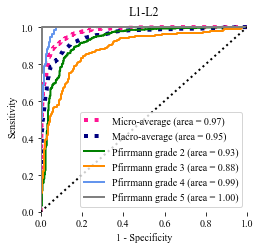

Balanced accuracy: 
0.7736485794423739


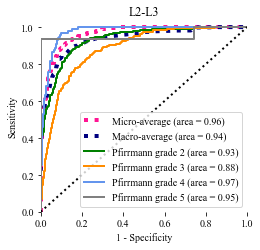

Balanced accuracy: 
0.7752017256170044


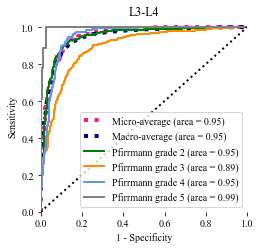

Balanced accuracy: 
0.7888649244790489


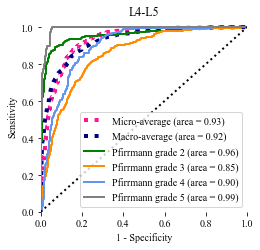

Balanced accuracy: 
0.7762224501736583


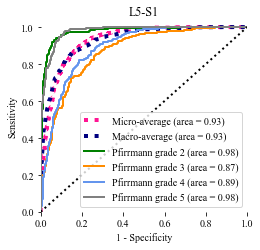

In [14]:
#### ROC for Pfirrmann grades ####
levels = ["L1-L2","L2-L3","L3-L4","L4-L5","L5-S1"]

plt.rc('font',family='Times New Roman')

for j in levels:
    df = dfx
    df = df.loc[df['Level'] == j]
    y_test = df[['gt_pf']].to_numpy()
    y_prediction = df[['Pfirrmann']].to_numpy()

    print('Balanced accuracy: ')
    print(balanced_accuracy_score(y_test, y_prediction))

    y_test = label_binarize(y_test, classes=[2, 3, 4, 5])
    y_prediction = label_binarize(y_prediction, classes=[2, 3, 4, 5])
    n_classes = y_test.shape[1]



    y_prob = df[["Pfirrmann_probability_1_2_sum", "Pfirrmann_probability_3", "Pfirrmann_probability_4", "Pfirrmann_probability_5"]].to_numpy()

    # for i in range(n_classes):
        # print(balanced_accuracy_score(y_test[:, i], y_prediction[:, i]))
        # print('Brier score: ')
        # print(brier_score_loss(y_test[:, i], y_prob[:, i])) #### Warning: I think this is the wrong way to do the Brier score 

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(n_classes):
        fpr[k], tpr[k], _ = roc_curve(y_test[:, k], y_prob[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #### For overlaid ROC plots ####
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    TNRfont = {'fontname':'Times New Roman'}
    plt.figure(figsize=(3.7, 3.5))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="Micro-average (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="Macro-average (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["green", "darkorange", "cornflowerblue", "gray"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label="Pfirrmann grade {0} (area = {1:0.2f})".format(i+2, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="dotted")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.03])
    plt.xlabel("1 - Specificity", **TNRfont)
    plt.ylabel("Sensitivity", **TNRfont)
    plt.title(j)
    plt.legend(loc="lower right")
    plt.box(False)
   
    plt.savefig(f'../figures/ROC_Pfirrmann_grade_{j}_220929.svg')
    plt.show()

Balanced accuracy: 
0.7813401487923446


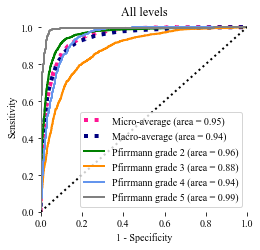

In [19]:
df = dfx
y_test = df[['gt_pf']].to_numpy()
y_prediction = df[['Pfirrmann']].to_numpy()

print('Balanced accuracy: ')
print(balanced_accuracy_score(y_test, y_prediction))

y_test = label_binarize(y_test, classes=[2, 3, 4, 5])
y_prediction = label_binarize(y_prediction, classes=[2, 3, 4, 5])
n_classes = y_test.shape[1]



y_prob = df[["Pfirrmann_probability_1_2_sum", "Pfirrmann_probability_3", "Pfirrmann_probability_4", "Pfirrmann_probability_5"]].to_numpy()

# for i in range(n_classes):
    # print(balanced_accuracy_score(y_test[:, i], y_prediction[:, i]))
    # print('Brier score: ')
    # print(brier_score_loss(y_test[:, i], y_prob[:, i])) #### Warning: I think this is the wrong way to do the Brier score 

fpr = dict()
tpr = dict()
roc_auc = dict()
for k in range(n_classes):
    fpr[k], tpr[k], _ = roc_curve(y_test[:, k], y_prob[:, k])
    roc_auc[k] = auc(fpr[k], tpr[k])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### For overlaid ROC plots ####
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(3.7, 3.5))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="Micro-average (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="Macro-average (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["green", "darkorange", "cornflowerblue", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="Pfirrmann grade {0} (area = {1:0.2f})".format(i+2, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="dotted")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title('All levels')
plt.legend(loc="lower right")
plt.box(False)

plt.savefig(f'../figures/ROC_Pfirrmann_grade_all_220929.svg')
plt.show()

Brier score: 
0.029825280515374853


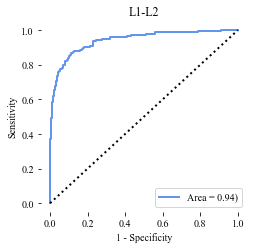

Brier score: 
0.05428607413807045


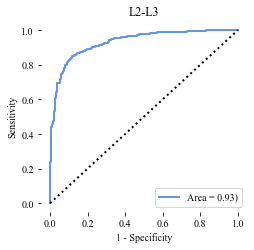

Brier score: 
0.06389868096739072


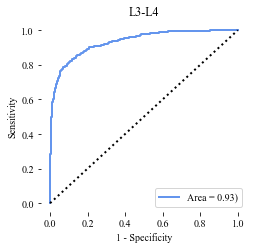

Brier score: 
0.08480456985917094


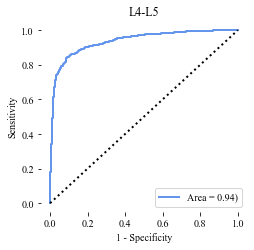

Brier score: 
0.08865586436625832


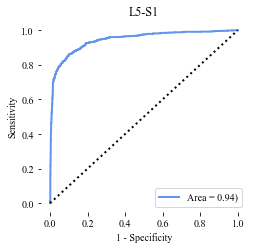

In [27]:
#### ROC for lower Modic changes ####

# df_mc_r = dfx[['project_ID', 'Level', 'UpperMC_probability', 'UpperMC_correct', 'UpperMarrow', 'gt_mc_r']].copy()
# df_mc_r.rename(columns = {'UpperMC_probability':'MC_probability', 'UpperMC_correct': 'MC_correct','UpperMarrow':'MC_prediction', 'gt_mc_r':'gt_mc'}, inplace = True)

# df_mc_c = dfx[['project_ID', 'Level', 'LowerMC_probability','UpperMC_correct', 'LowerMarrow', 'gt_mc_c']].copy()
# df_mc_c.rename(columns = {'LowerMC_probability':'MC_probability','UpperMC_correct': 'MC_correct', 'LowerMarrow':'MC_prediction', 'gt_mc_c':'gt_mc'}, inplace = True)

# dfs = [df_mc_r, df_mc_c]
# df_mc = pd.concat(dfs)

df_mc = pd.read_csv('../data/ROC_testing_3.csv')

for j in levels:
    df = df_mc
    df = df.loc[df['Level'] == j]
    y_test = df[['gt_mc']].astype('int32').to_numpy()
    y_prediction = df[['MC_prediction']].astype('int32').to_numpy()

    # for i in range(n_classes):
    # print('Balanced accuracy: ')
    # print(balanced_accuracy_score(y_test, y_prediction))
    

    y_prob = df[["MC_gt_probabilities"]].to_numpy()
    print('Brier score: ')
    print(brier_score_loss(y_test, y_prob))

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    #### For single ROC plot ####
    # for i in range(n_classes):
    plt.figure(figsize=(3.7, 3.5))
    plt.plot(
        fpr,
        tpr,
        color="cornflowerblue",
        label="Area = %0.2f)" % roc_auc,
        linewidth=2
    )
    plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="dotted")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.title(j)
    plt.legend(loc="lower right")
    plt.box(False)
 
    plt.savefig(f'../outputs/ROC_MC_{j}_220929.svg')
    plt.show()

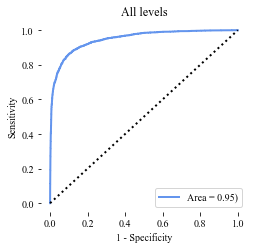

In [28]:

df = df_mc

y_test = df[['gt_mc']].astype('int32').to_numpy()
y_prediction = df[['MC_prediction']].astype('int32').to_numpy()

# for i in range(n_classes):
# print('Balanced accuracy: ')
# print(balanced_accuracy_score(y_test, y_prediction))


y_prob = df[["MC_gt_probabilities"]].to_numpy()
# print('Brier score: ')
# print(brier_score_loss(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#### For single ROC plot ####
# for i in range(n_classes):
plt.figure(figsize=(3.7, 3.5))
plt.plot(
    fpr,
    tpr,
    color="cornflowerblue",
    label="Area = %0.2f)" % roc_auc,
    lw=2
)
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="dotted")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title(f"All levels")
plt.legend(loc="lower right")
plt.box(False)

plt.savefig(f'../outputs/ROC_MC_all_220929.svg')
plt.show()